In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

# Reading in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Pre-Processing

In [5]:
# Deaing with null values and converting categorical columns to appropriate datatype.
# List of categorical columns to process
categorical_columns = [
    'temp_of_extremities',
    'peripheral_pulse',
    'mucous_membrane',
    'capillary_refill_time',
    'pain',
    'peristalsis',
    'abdominal_distention',
    'nasogastric_tube',
    'nasogastric_reflux',
    'rectal_exam_feces',
    'abdomen',
    'abdomo_appearance',
    'surgery',
    'surgical_lesion',
    'cp_data',
    'outcome',
    'age'
]

# Looping through the categorical columns and filling missing values w/mode
for column in categorical_columns:
    # Fill missing values with the mode
    mode_value = train[column].mode()[0]
    train[column].fillna(mode_value, inplace=True)
    # Convert the data type to categorical
    train[column] = train[column].astype('category')

## Dealing with outliers in numerical data

## Rectal Temp
# Calculate the Z-scores for 'rectal_temp'
z_scores = np.abs(stats.zscore(train['rectal_temp']))
# Defining a threshold for identifying outliers (e.g., 3 standard deviations)
threshold = 3
# Identifying outliers based on the Z-scores
outliers_mask = z_scores > threshold
# Imputing outliers with the mean value of 'rectal_temp'
mean_rectal_temp = train['rectal_temp'].mean()
train.loc[outliers_mask, 'rectal_temp'] = mean_rectal_temp

# Creating dataframe with the outliers
outliers_df = train[outliers_mask]

## Pulse
# Calculating the 99th percentile value
percentile_99 = np.percentile(train['pulse'], 99)
# Imputing values above 99th percentile w/the 99th percentile
train.loc[train['pulse'] > percentile_99, 'pulse'] = percentile_99

## Respiratory Rate
# Calculating the 99th percentile value
percentile_99 = np.percentile(train['respiratory_rate'], 99)
# Replacing values above the 99th percentile with the 99th percentile value
train['respiratory_rate'][train['respiratory_rate'] > percentile_99] = percentile_99

## Packed Cell Volume
# Calculating the Z-scores for 'rectal_temp'
z_scores = np.abs(stats.zscore(train['packed_cell_volume']))
# Defining a threshold for identifying outliers (e.g., 3 standard deviations)
threshold = 3
# Identifying outliers based on the Z-scores
outliers_mask = z_scores > threshold
# Imputing outliers with the mean value of 'rectal_temp'
mean_rectal_temp = train['packed_cell_volume'].mean()
train.loc[outliers_mask, 'packed_cell_volume'] = mean_rectal_temp

## Total Protein
# Calculating the 25th and 75th percentiles
percentiles = np.percentile(train['total_protein'], [25, 75])
# Defining a function to impute outliers in a cluster with the cluster's mean
def impute_outliers_with_mean(cluster_data):
    cluster_mean = cluster_data.mean()
    cluster_data_copy = cluster_data.copy()
    cluster_data_copy[cluster_data_copy < percentiles[0]] = cluster_mean
    cluster_data_copy[cluster_data_copy > percentiles[1]] = cluster_mean
    return cluster_data_copy
# Performing k-means clustering to identify clusters
kmeans = KMeans(n_clusters=2)  # Using 2 clusters because this data was clustered in two areas on initial exploratory analysis
train['cluster'] = kmeans.fit_predict(train[['total_protein']])
#Replacing outliers in clusters w/cluster mean
for cluster_id in train['cluster'].unique():
    cluster_data = train[train['cluster'] == cluster_id]['total_protein']
    cluster_data_imputed = impute_outliers_with_mean(cluster_data)
    train.loc[train['cluster'] == cluster_id, 'total_protein'] = cluster_data_imputed
train.drop('cluster', axis=1, inplace=True)

## Abdominal Protein
# Calculating the 99th percentile value
percentile_99 = np.percentile(train['abdomo_protein'], 99)
# Replacing values above the 99th percentile with the 99th percentile value
train['abdomo_protein'][train['abdomo_protein'] > percentile_99] = percentile_99

## Lesion 1
# Calculating the 99th percentile value
percentile_99 = np.percentile(train['lesion_1'], 99)
# Replacing values above the 99th percentile with the 99th percentile value
train['lesion_1'][train['lesion_1'] > percentile_99] = percentile_99

## Lesion 2 & Lession 2 values are not useful, dropping these variables because most values are = 0.
train.drop('lesion_2', axis=1, inplace=True)
test.drop('lesion_2', axis=1, inplace=True)
train.drop('lesion_3', axis=1, inplace=True)
test.drop('lesion_3', axis=1, inplace=True)

/var/folders/gq/l73fcf41067355zj79g9b5hm0000gn/T/ipykernel_40648/3699469330.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['respiratory_rate'][train['respiratory_rate'] > percentile_99] = percentile_99
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/gq/l73fcf41067355zj79g9b5hm0000gn/T/ipykernel_40648/3699469330.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

## Initial visual data exploration

c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mason\AppData\Local\Programs\Python\Python3

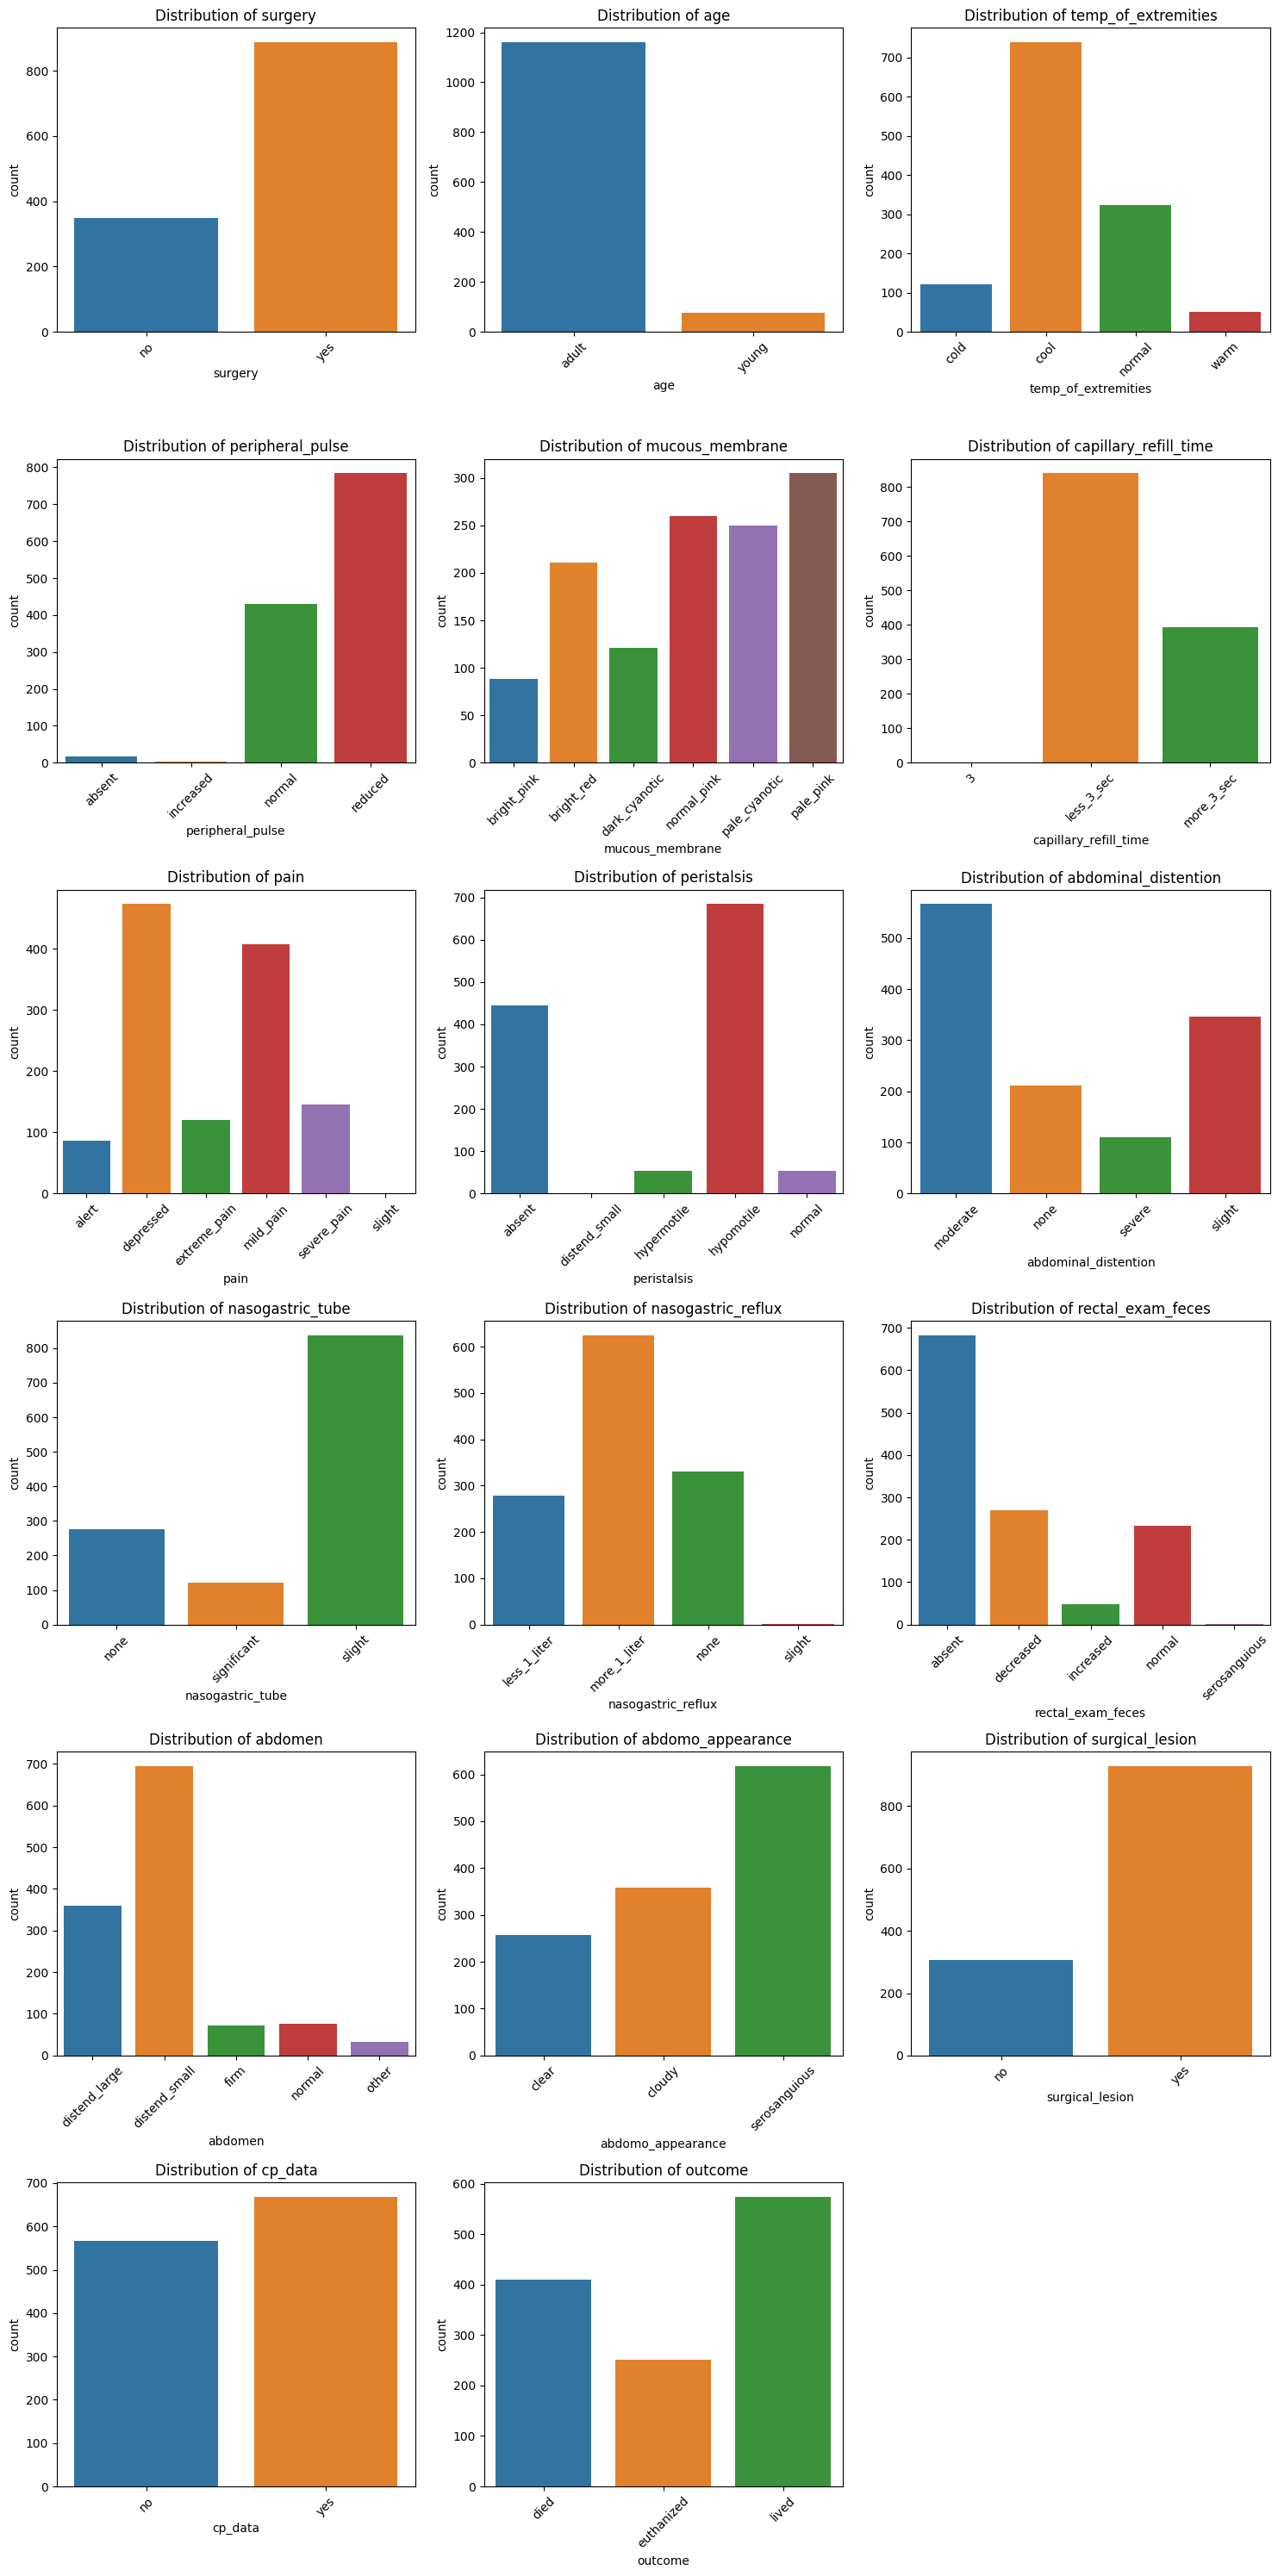

c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mason\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

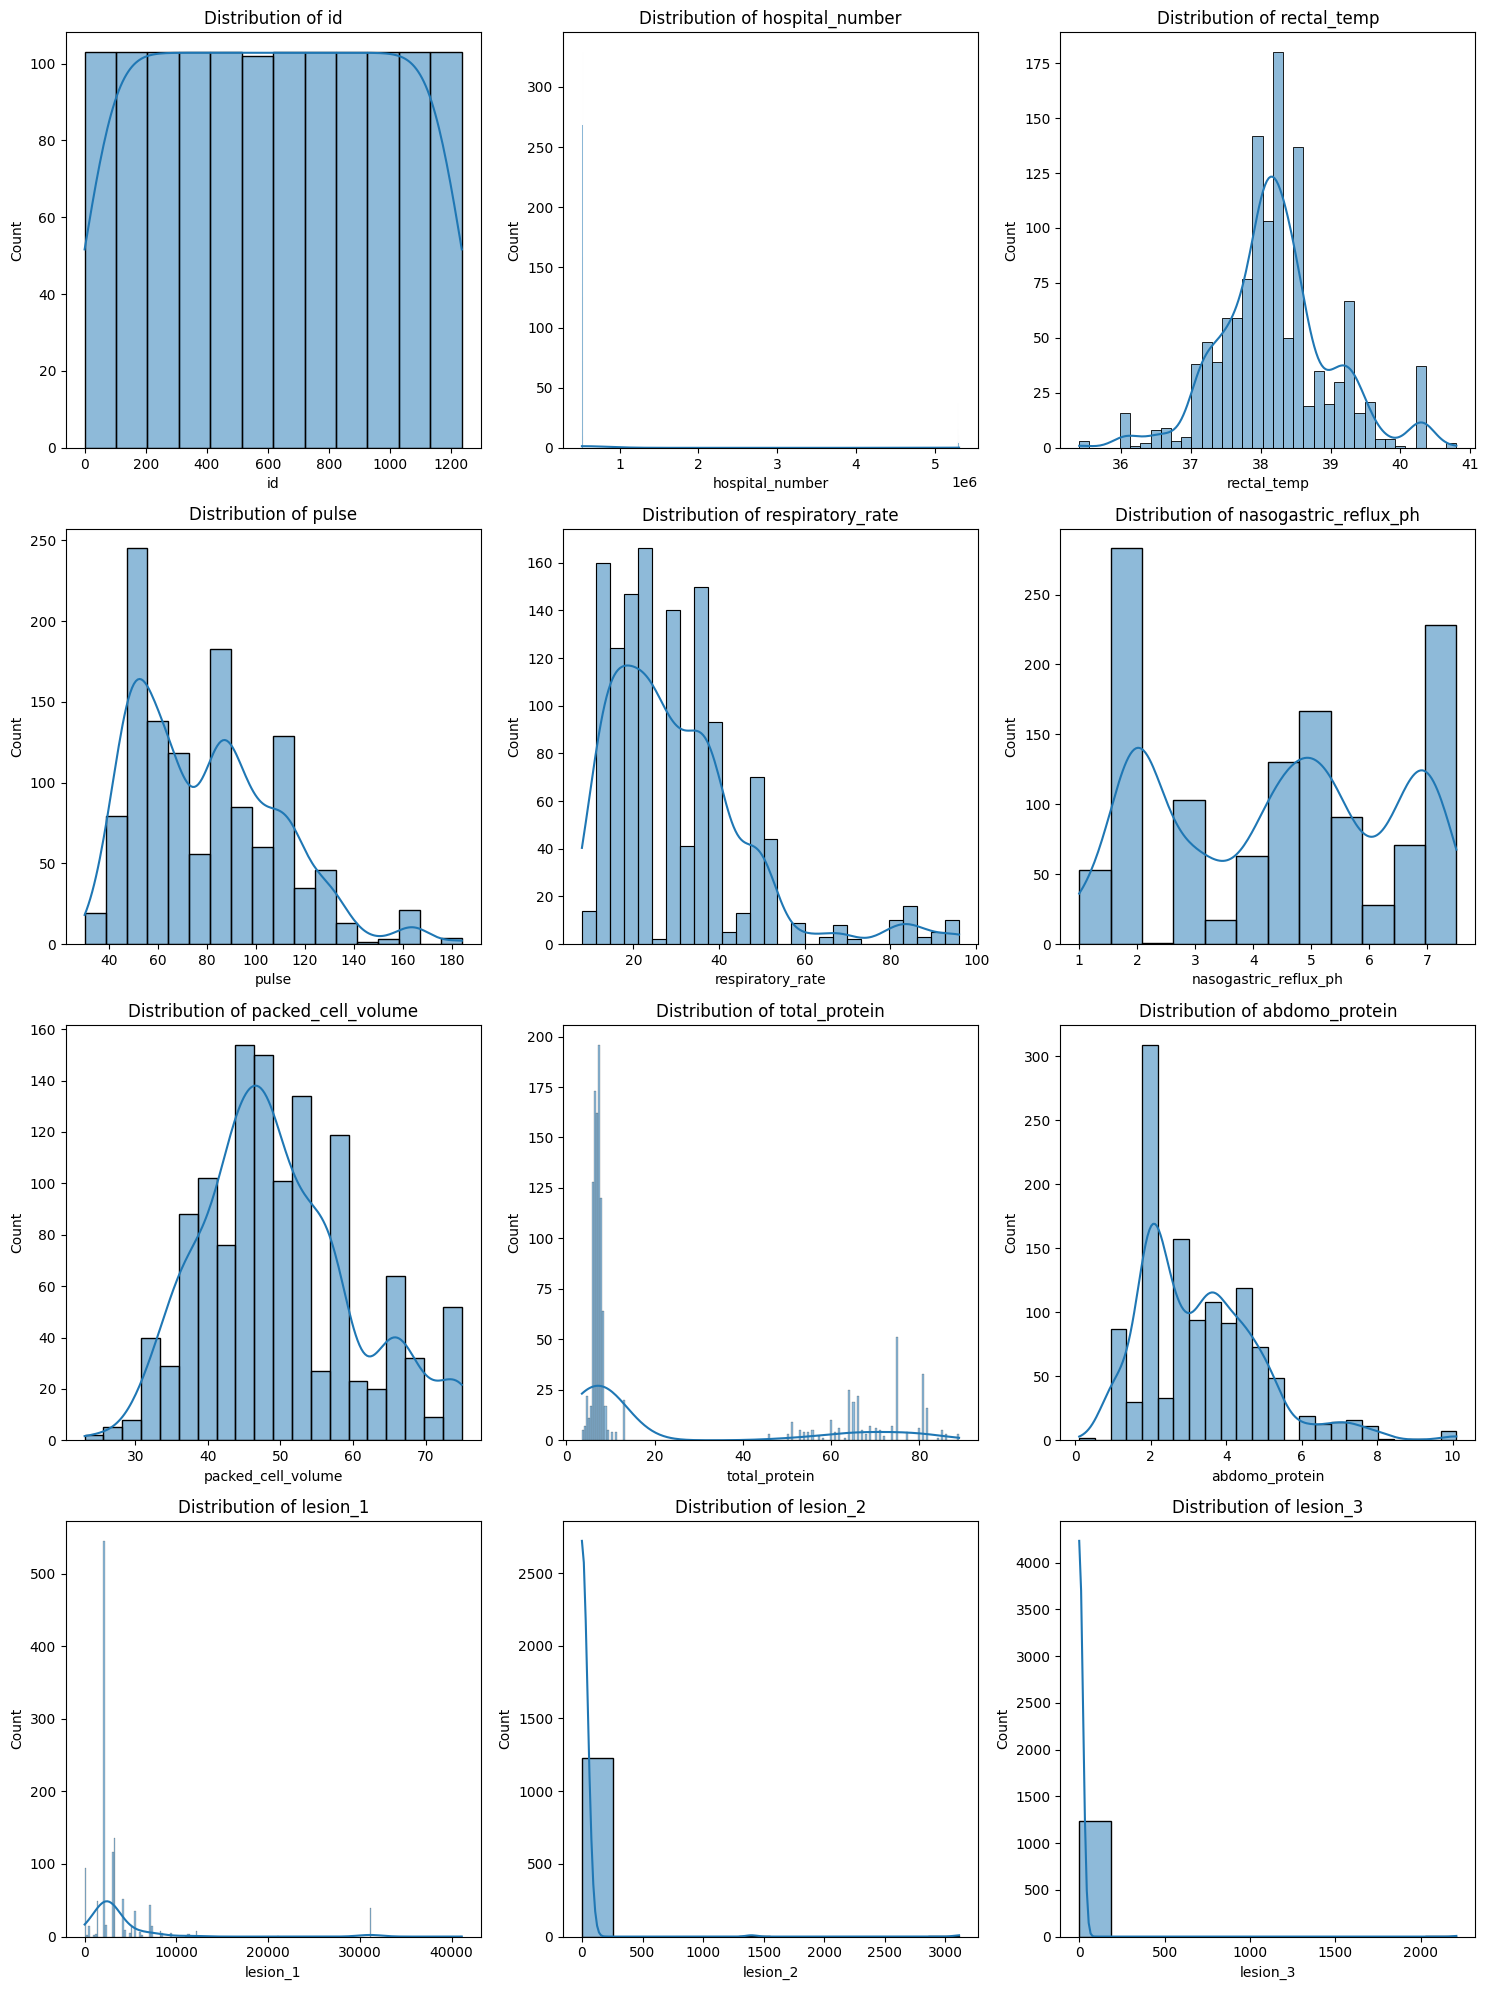

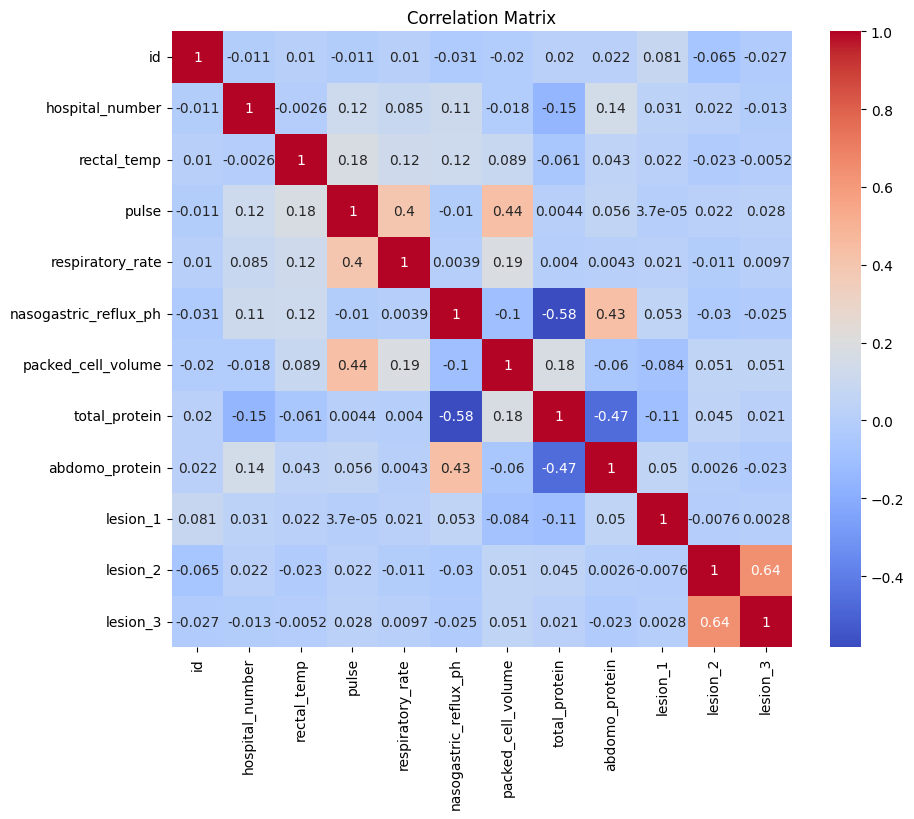

In [4]:
# Deaing with null values and converting categorical columns to appropriate datatype.
# List of categorical columns to process
categorical_columns = [
    'temp_of_extremities',
    'peripheral_pulse',
    'mucous_membrane',
    'capillary_refill_time',
    'pain',
    'peristalsis',
    'abdominal_distention',
    'nasogastric_tube',
    'nasogastric_reflux',
    'rectal_exam_feces',
    'abdomen',
    'abdomo_appearance',
    'surgery',
    'surgical_lesion',
    'cp_data',
    'outcome',
    'age'
]

# Looping through the categorical columns and filling missing values w/mode
for column in categorical_columns:
    # Fill missing values with the mode
    mode_value = train[column].mode()[0]
    train[column].fillna(mode_value, inplace=True)
    # Convert the data type to categorical
    train[column] = train[column].astype('category')

train=train.dropna(axis=1)

# Distribution of categorical variables
categorical_columns = train.select_dtypes(include=['category']).columns
num_cat_cols = len(categorical_columns)
cols_per_row = 3  # Number of columns per row in the grid
rows = (num_cat_cols + cols_per_row - 1) // cols_per_row  # Calculate the number of rows

plt.figure(figsize=(15, 5 * rows))  # Adjust the figure size as needed

for i, column in enumerate(categorical_columns):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.countplot(data=train, x=train[column])
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

# Distribution of numeric variables
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
num_num_cols = len(numeric_columns)
cols_per_row = 3  # Number of columns per row in the grid
rows = (num_num_cols + cols_per_row - 1) // cols_per_row  # Calculate the number of rows

plt.figure(figsize=(15, 5 * rows))  # Adjust the figure size as needed

for i, column in enumerate(numeric_columns):
    plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(data=train, x=train[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

# Correlation matrix for numeric variables
correlation_matrix = train[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
categorical_columns

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data', 'outcome'],
      dtype='object')

In [14]:
# Defining X and Y values
X_train=train.drop('outcome', axis=1)
y_train=train['outcome']

# Defining list of categorical columns
categorical_columns = [
    'temp_of_extremities',
    'peripheral_pulse',
    'mucous_membrane',
    'capillary_refill_time',
    'pain',
    'peristalsis',
    'abdominal_distention',
    'nasogastric_tube',
    'nasogastric_reflux',
    'rectal_exam_feces',
    'abdomen',
    'abdomo_appearance',
    'surgery',
    'surgical_lesion',
    'cp_data',
    'outcome',
    'age'
]

# Seperating numerical columns from categorical columns
numerical_columns=[col for col in X_train.columns if col not in categorical_columns]

# Getting dummies for categorical columns
X_train_categorical=pd.getdummies(X_train[categorical_columns], columns=categorical_columns)

# Combining one hot encoded categorical columns with numerical columns
X_train=pd.concat([X_train_categorical, X_train[numerical_columns]], axis=1)

# Creating and training the rf classifier
rf_classifier=RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train,y_train)

# Preprocessing the test data in the same way we did w/the training data
test_X_categorical=pd.get_dummies(test[categorical_columns],columns=categorical_columns)
test_X = pd.concat([test.drop(categorical_columns)])


